# THz STM Simulation

This is the master simulation. This contains all of the functions necessary to run the code, along with basic examples. For more imformation on a specific section/operation, see the ipython notebook referenced at the beginning of that section. 

Possible Improvements: Creating a generalizable even/odd order function for n given integers (instead of the odd and even functions used in this notebook). 

## Part 1: Pulse Generation and Charge Rectification

This part focuses on simulating experimental data that will be used to test methods of analysis. For more information, see THz_pulse_model.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import curve_fit
import pandas as pd
sns.set()
%matplotlib inline

### 1.1 Generating a Pulse With Desired Phase

This section takes the $\sin \times gaussian$ and does a fast fourier transform. The phase is changed manually and the waveform is reconstructed with the physics of the system preserved. A realistic THz pulse has the form $\cos \times gaussian$. However, a simple implementation of this waveform has a non-zero time integral; this is a non-physical laser pulse. To correct this, the phase of a $\sin \times gaussian$ is changed via fourier transform which preserves the result of the time integral.

In [2]:
## Define waveform ##
def Efield(t, E0 = 1, w=2*np.pi*0.8, s = 0.4 , phi = 0 ):
    return E0*np.sin(w*t+phi)*np.exp(-0.5*(t)**2/s**2) # sin*gaussian

Integral: 5.551115123125783e-17


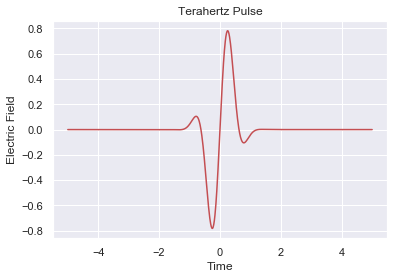

In [3]:
## Plot it ##
t = np.linspace(-5,5,1000)
plt.plot(t, Efield(t, w = 0.8*2*np.pi, s = 0.4), 'r')
plt.title("Terahertz Pulse")
plt.xlabel("Time")
plt.ylabel("Electric Field")
print("Integral:", np.trapz(Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = 0),t))

Integral: 0.13283504548731645


'Problem: Non-Zero Integral'

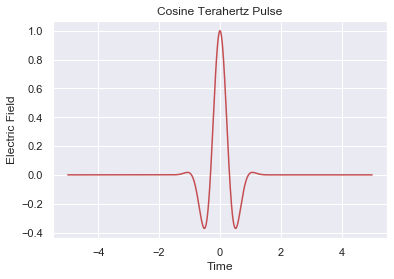

In [4]:
## Cosine Times Gaussian Example ##
t = np.linspace(-5,5,1000)
plt.plot(t, Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = np.pi/2), 'r')
plt.title("Cosine Terahertz Pulse")
plt.xlabel("Time")
plt.ylabel("Electric Field")
print("Integral:", np.trapz(Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = np.pi/2),t))
"""Problem: Non-Zero Integral"""

In [5]:
## Define FFT ##

def fourier(t, func):   
    
    freq = np.arange(-1/(abs(t[0])-abs(t[1]))/2, 1/(abs(t[0])-abs(t[1]))/2 , 1/(t[-1]-t[0]))
    ft = np.fft.fft(func)
    ftshift = np.fft.fftshift(ft)   
    
    return np.array([freq, ft, ftshift])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Integral of InvFFT: (-3.9905273904846305e-06+3.041848280949425e-21j)


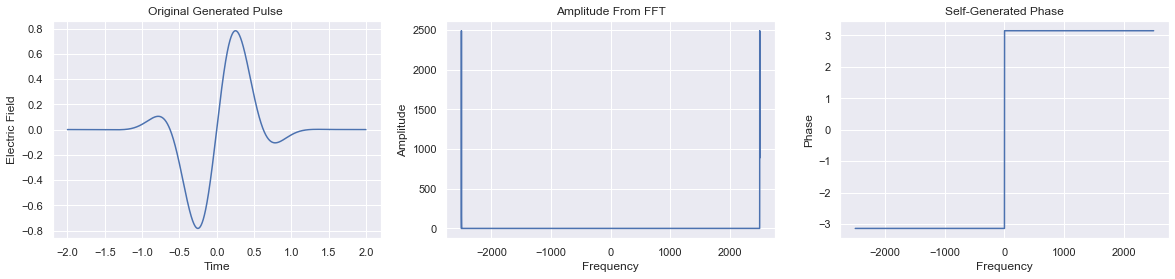

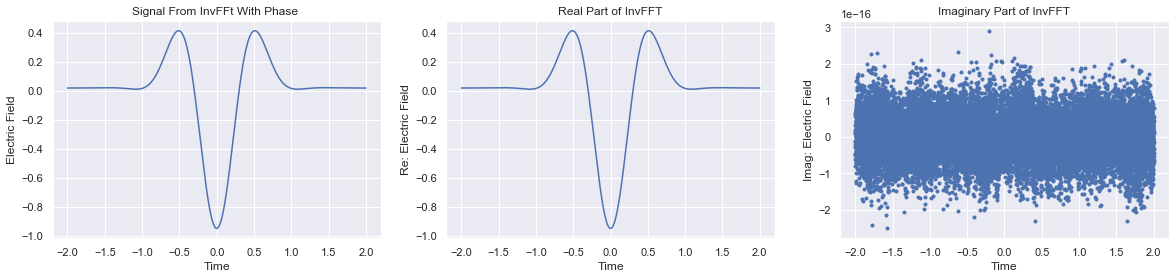

In [6]:
## Generating a pulse with a different phase ##

t = np.linspace(-2,2,20020)
ft = fourier(t , func = Efield(t, w = 2*np.pi*0.8, s = 0.4))
amp = np.abs(ft[1])

phi = np.zeros(len(ft[0]))  # make array filled with zeros

for i in range(-10010,10010):      # fill array with values
    if i >= 0:
        phi[i] = -np.pi
    if i < 0:
        phi[i] = np.pi

        
pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
signal = []  # make empty list

for i in range(10010,20020):  # invFFT gives signal shifted, but inFFTshift won't work; this is a manual shift
    signal.append(pulse[i])
    
for i in range(10010):
    signal.append(pulse[i])
    
## Plots ##

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,4))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,4))

ax1.plot(t, Efield(t, w = 2*np.pi*0.8, s = 0.4))
ax1.set_title("Original Generated Pulse ")
ax1.set_xlabel("Time")
ax1.set_ylabel("Electric Field")

ax2.plot(ft[0],amp)
ax2.set_title("Amplitude From FFT")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Amplitude")

ax3.plot(ft[0],phi)
ax3.set_title("Self-Generated Phase")
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Phase")

ax4.plot(t,signal)
ax4.set_title("Signal From InvFFt With Phase ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Electric Field")

ax5.plot(t,np.real(signal))
ax5.set_title("Real Part of InvFFT")
ax5.set_xlabel("Time")
ax5.set_ylabel("Re: Electric Field")

ax6.plot(t,np.imag(signal), '.')
ax6.set_title("Imaginary Part of InvFFT")
ax6.set_xlabel("Time")
ax6.set_ylabel("Imag: Electric Field")


print("Integral of InvFFT:",integrate.simps(y = signal, x = t)) 

In [7]:
def change_phase(t,V,phase=0):
    
    """The change_phase function changes the phase of the input waveform.
    
       ***PARAMETERS***
       
       t: Time domain.
       V: Input waveform.
       phase: Desired phase.
       
       """
    
    
    ft = fourier(t , V)
    amp = np.abs(ft[1])
    phi = np.zeros(len(ft[0]))  # make array filled with zeros
    
    if phase == 0: # avoids redundant calculation
        pass
    
    else:
        for i in range(-1001,1001):      # fill array with values
            if i >= 0:
                phi[i] = -phase
            if i < 0:
                phi[i] = phase


    pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
    signal = []  # make empty list

    for i in range(1001,2002):  # invFFT gives signal shifted, but inFFTshift won't work; this is a manual shift
        signal.append(pulse[i])

    for i in range(0,1001):
        signal.append(pulse[i])

    signal = np.asarray(signal)/max(abs(pulse)) # this defines signal for the whole notebook (and normalizes it)
    
    return signal




In [8]:
## Define Signal for Whole Notebook ##

t = np.linspace(-4,4,2002)
signal = change_phase(t,V=Efield(t))

### 1.2 Current Simulation

This section generates different I-V curves that will be used in the rest of the simulation.

In [9]:
## Generate current object ##

class current():
    
    """The current class is used to simulate different theoretical/toy I-V models. To use: Call current and
       define the desired model as True. Whenever you want to use the model, call the calculate function and
       feed in the desired V. To get an I-V, set V equal to any linspace array of desired size. To get I(t), 
       set V equal to your signal, or V(t). Each model has different parameters and should be reviewed accordingly.
       All current types share the same parameters except Simmons. The standard numerical values are set as a 
       default in that case."""
    
    
    
    # Initialize current types and variables # 
    
    def __init__(self, height1=1, squeeze1=1, pos1=0, height2=1, squeeze2=1, pos2=0, shift=0, 
                 phi_t=8.01088e-19, phi_s=8.01088e-19, z = 0.5e-9, A=1e-9, 
                 erf=False, ohm=False, cubic=False, exp=False, double_erf=False, step=False, Simmons=False):
        
        self.height1 = height1
        self.squeeze1 = squeeze1
        self.pos1 = pos1
        self.height2 = height2
        self.squeeze2 = squeeze2
        self.pos2 = pos2
        self.shift = shift
        self.phi_t = phi_t
        self.phi_s = phi_s
        self.z = z
        self.A = A
        
        
        self.erf = erf
        self.ohm = ohm
        self.cubic = cubic
        self.exp = exp
        self.double_erf = double_erf
        self.step = step
        self.Simmons = Simmons
        
    # Call calculate to generate I[V(t)] #  
        
    def calculate(self, V):
        
        if self.erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.shift
        if self.double_erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.height2*special.erf((V - self.pos2)*self.squeeze2) + self.shift
        if self.cubic == True:
            calculate = self.height1*(V*self.squeeze1 - self.pos1)**3 + self.height2*(V*self.squeeze2 - self.pos2) + self.shift
        if self.step == True:
            calculate = self.height1 * (V > self.pos1)
        if self.ohm == True:
            calculate = (V - self.pos1)/self.height1 + self.shift
        if self.exp == True:
            calculate = self.height1*np.exp(-(V*self.squeeze1 - self.pos1)) + self.shift
        if self.Simmons == True:

            I = []
            
            for i in range(0,len(V)):

                if np.real(V[i])*1.60217662e-19 > -self.phi_t and np.real(V[i])*1.60217662e-19 < self.phi_s:
                    phi_bar = (self.phi_t+self.phi_s-abs(V[i])*1.60217662e-19)/2
                    delta = self.z
 
                if np.real(V[i])*1.60217662e-19 >= self.phi_s:
                    phi_bar = self.phi_t/2
                    delta = self.z*self.phi_t/(self.phi_t-self.phi_s+abs(V[i])*1.60217662e-19)
                    beta = 23/24

                if np.real(V[i])*1.60217662e-19 <= -self.phi_t:
                    phi_bar = self.phi_s/2
                    delta = self.z*self.phi_s/(self.phi_s-self.phi_t+abs(V[i])*1.60217662e-19)
                    beta = 23/24

                if np.real(V[i])*1.60217662e-19 >= 0 and np.real(V[i])*1.60217662e-19 < self.phi_s:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19-self.phi_s+self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                
                if np.real(V[i])*1.60217662e-19 > -self.phi_t and np.real(V[i])*1.60217662e-19 < 0:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19+self.phi_s-self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2

                if np.real(V[i]) >= 0:
                    I.append(1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))

                if np.real(V[i]) < 0: 
                    I.append(-1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
       
            calculate = np.asarray(I)
   
        else:
            pass
        
        return calculate

Text(0, 0.5, 'Current')

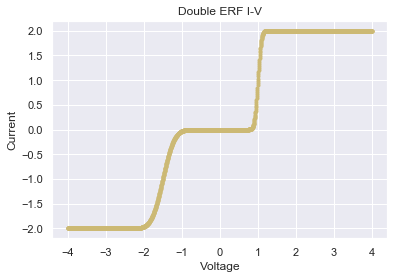

In [10]:
## Example ##

I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10, squeeze2 = 3, double_erf = True) # call desired current typ
voltage_sweep = np.linspace(-4,4,2000)
plt.plot(voltage_sweep, I.calculate(voltage_sweep), 'y.')
plt.title("Double ERF I-V")
plt.xlabel("Voltage")
plt.ylabel('Current')


### 1.3 Charge Rectification

This section generates theoretical Q(V) data for different I-V curves. Within this seciton is a function that sweeps through different phases of waveforms and a function that sweeps through different amplitudes of waveforms that probe a given I-V.

In [11]:
## Define Phase Sweep ##

def phase_sweep(phi_range, sweep_pts, freq, fft, current, t):
    
    """This function generates a set of waveforms with different phases. """
    
    phi_0 = -phi_range/2
    amp = np.abs(fft)
    phase = []
    I = []
    I_integral = []
    sig_array = []
    sig_integral = []
    problem = []
    
    
    for i in range(0,sweep_pts): # *****Check to see if this will mess up length stuff

        phi = np.zeros(len(freq))       # re-initialize phi matrix
        

        for j in range(0, len(freq)):      # fill array with values
            if j >= int(len(freq)/2):
                phi[j] = phi_0
            else:
                phi[j] = -phi_0
        
        pulse = np.fft.ifft(amp*np.exp(1j*phi)) # get pulse back with new phase
        signal = []
         
        for k in range(int(len(freq)/2),int(len(freq))):  # manually shift ifft
            signal.append(pulse[k])

        for l in range(int(len(freq)/2)):
            signal.append(pulse[l])
        
        

        phase.append(phi_0)             # store phase values
        signal = np.asarray(signal) 
        I_integral.append(integrate.simps(x=t, y=current.calculate(signal))) # compute I(t) integral
        I.append(current.calculate(signal))
        sig_array.append(signal)
        sig_integral.append(integrate.simps(x=t, y=signal))
        phi_0 += phi_range/sweep_pts     # compute new phi for next loop
        
            
        
        #plt.plot(t, signal)            # Plot envelope of signals

    phase = np.asarray(phase)
    I_integral = np.asarray(I_integral)
    I = np.asarray(I)
    sig_array = np.asarray(sig_array)
    
    return [phase, I_integral, sig_array, I, sig_integral]



In [12]:
## Generate Q[V(phi)] map ##

def amplitude_sweep(t, current, amp_pts, maxE0, phi_range, phase_pts, minE0=0, Simmons=False):
    
    """The amplitude_sweep function takes in a theoretical I-V and produces a rectified charge map by
       sweeping driving amplitude (waveform maximums) and phase. NOTE: Due to the if/and statements 
       in the Simmons I-V a separate operation must be done to calculate this case. If the current type
       is the Simmons model, define Simmons=True.
       
       ***PARAMETERS***
       
       t: Waveform time domain.
       current: Chosen I-V type from current class.
       amp_pts: Defines number of points in amplitude sweep.
       maxE0: Max waveform amplitude in amplitude sweep.
       phi_range: Phase sweep range.
       phase_pts: Number of points in phase sweep.
       min_E0: Min waveform amplitude in amplitude sweep.
       Simmmons: Toggle Simmons model calculation.
       
       """
 
    E0 = np.linspace(minE0,maxE0,amp_pts) # create array of sweep parameters
    I_integral = []  # make empty list
    ft = fourier(t, func = Efield(t,w = 2*np.pi*0.8, s = 0.4, E0=1)) # FFT
    sweep = phase_sweep(phi_range = phi_range, sweep_pts = phase_pts , freq = ft[0], fft = ft[1], current = I , t = t) # Sweep phase and create signal

    
    
    if Simmons == True:                  # Due to piecewise nature of Simmons I-V, an additional loop over each point is required
       
        for i in range(0,amp_pts):
            
            volt_sweep = []
           
            for j in range(0,len(sweep[2])):
                volt_sweep.append(integrate.simps(x=t, y = current.calculate(V=E0[i]*sweep[2][j]))) # calculate the integral and store it into the empty list
  
            I_integral.append(volt_sweep)
        I_integral = np.asarray(I_integral) #turn list into numpy array


    else:
       
        for i in range(0,amp_pts):

            I_integral.append(integrate.simps(x=t, y = current.calculate(V=E0[i]*sweep[2]))) # calculate the integral and store it into the empty list

        I_integral = np.asarray(I_integral) #turn list into numpy array
        
    return [sweep, E0, I_integral]

In [13]:
# Generate Simulated Data #

I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10,squeeze2 = 10, double_erf = True) # call current with desired attributes
#I = current(Simmons = True)
t = np.linspace(-4,4,2002) 
amp_sweep = amplitude_sweep(t=t, current=I, phi_range = 2*np.pi, phase_pts = 50, maxE0 = 8, minE0 = 0, amp_pts = 100) # call function


C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


Text(0, 0.5, 'Amplitude')

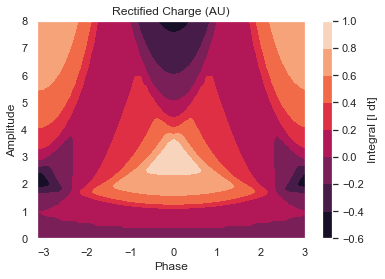

In [14]:
# Plot #
fig, ax1 = plt.subplots()
cep = ax1.contourf(amp_sweep[0][0], amp_sweep[1], amp_sweep[2]) # contour (color) map 
fig.colorbar(cep, label = 'Integral [I dt]') # apply colorbar
ax1.set_title('Rectified Charge (AU)')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Amplitude')

## Part 2: Current Rectification and Polynomial Fitting

This part focuses on using simulated data to test out data analysis models and extract I-V curves from experimental data. More information on this section can be found in the notebook Current_Rectification.ipynb

### 2.1 Reconstructing I-V Curve Using the Polynomial Fitting Method

This section focuses on creating a function which takes experimental data (rectified charge) and reproduces an I-V curve. In this section the method is proved to work with simulated experimental data.

In [15]:
## Function that creates nth order polynomial(s) for fit ##
def arb_poly(x, *params):
    return sum([p*(x**(i+2)) for i, p in enumerate(params)])

def arb_odd_poly(x, *params):
    return sum([p*(x**(2*i+3)) for i, p in enumerate(params)])

def arb_even_poly(x, *params):
    return sum([p*(x**(2*i+2)) for i, p in enumerate(params)])

In [16]:
def rectify1(V, E0, t, Q, fit_terms):
    
    """The rectify1 function fits the entirety of rectified charge data with minimal adjustment
       to the input data. This function is much more data friendly and less computationally
       expensive.
        
       The rectify1 function takes in experimental values for the input waveform, amplitudes
       (waveform maximums/minimums), and the result from the Q[V] sweep. It fits a polynomial
       of order 2 and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform.
       E0: Waveform maximums from sweep.
       t: Waveform time domain.
       Q: Rectified charge data.
       
       """
    
    a_n = []                
    rec_current = [] 
    I_t = []
   
    popt, pcov = curve_fit(f = arb_poly, xdata=E0 ,   # fit the data
                       ydata = np.real(Q), p0=[1]*(fit_terms)) # default initial guess to be 1



    for i in range(0,len(popt)):
        a_n.append(popt[i]/integrate.simps(V**(i+2),x=t)) 

    a_n = np.asarray(a_n)    

    
    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  # reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

In [17]:
def rectify2(V, pos_E0, neg_E0, t, Q_pos, Q_neg, fit_terms):
    
    """rectify2 fits the even and odd ordered terms of the polynomial. Some complications with
       this method are due to the symmetry of the experimental values about V=0. It is also more
       computationally expensive. When using rectify2, E0 and rectified charge data must be 
       separated by its positive and negative parts.
       
       The rectify2 function takes in experimental values for the input waveform, amplitudes
       (waveform maximums and minimums from positive and negative sweeps respectively), and the 
       results from the Q[V(phi=0)] and Q[V(phi=pi)] sweeps. It fits a polynomial of order 2 
       and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform.
       pos_E0: Waveform maximums from sweep using V(phi=0).
       neg_E0: Waveform minimums from sweep using V(phi=pi).
       t: Waveform time domain.
       Q_pos: Q[V(phi=0)] sweep data. Positive cosine wave as a function of waveform maximums.
       Q_neg: Q[V(phi=pi)] sweep data. Negative cosine wave as a function of waveform maximums.
       
       """
    
    a_n = []                
    rec_current = [] 
    I_t = []

    even_order = (Q_pos+Q_neg)/2
    odd_order = (Q_pos-Q_neg)/2
    
    popt1, pcov1 = curve_fit(f = arb_even_poly, xdata=pos_E0 ,   # fit the even ordered data
                       ydata = np.real(even_order), p0=[1]*(fit_terms)) # default initial guess to be 1


    popt2, pcov2 = curve_fit(f = arb_odd_poly, xdata=pos_E0 ,   # fit the odd ordered data
                       ydata = np.real(odd_order), p0=[1]*(fit_terms))  # default initial guess to be 1


    for i in range(0,len(popt1)):
        a_n.append(popt1[i]/integrate.simps(V**(2*i+2),x=t)) 
        a_n.append(popt2[i]/integrate.simps(V**(2*i+3),x=t))

    a_n = np.asarray(a_n)    
    E0 = np.concatenate((neg_E0,pos_E0), axis=0)
    
    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  # reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Rectified Charge')

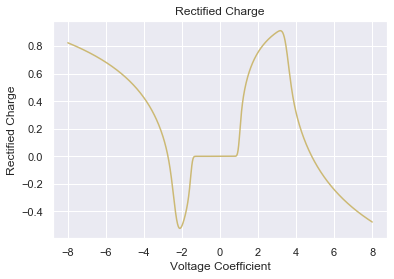

In [18]:
## Generating Q(V) data ##

E0 = np.linspace(-8,8,2002)
t = np.linspace(-4,4,2002) # try to keep consistent with rest of notebook
sweep_pts = 2002

sweep = []

for i in range(0,len(E0)):
    sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V

sweep = np.asarray(sweep)
   
plt.plot(E0,sweep, 'y-')
plt.title("Rectified Charge")
plt.xlabel('Voltage Coefficient')
plt.ylabel('Rectified Charge')

In [19]:
def Q_data1(t, I, V, E0):
    
    """The Q_data1 function generates data that can be fed into rectify1 function.
    
       The Q_data1 function simulates rectified charge as a function of driving amplitudes. 
       Use this function to compare theoretical values.
       
       ***PARAMETERS***
       
       t: Time domain.
       I: Current type. Must be an activated class.
       V: Waveform.
       E0: List of driving amplitudes. Must go from 0 to E0max (i.e. [0,E0]).
       """
    
    sweep = []

    for i in range(0,len(E0)):
        sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*V))) # probe positive portion of I-V
      
    sweep = np.asarray(sweep)
   
    return sweep




In [20]:
def Q_data2(t, I, V, E0):
    
    """The Q_data function simulates rectified charge as a function of driving amplitudes
       for the V(phi=0) and V(phi=pi) cases. Use this function to compare to theoretical
       values.
       
       ***PARAMETERS***
       
       t: Time domain.
       I: Current type. Must be an activated class.
       V: Waveform.
       E0: List of driving amplitudes. Must go from 0 to E0max (i.e. [0,E0]).
       """
    
    pos_sweep = []
    neg_sweep = []

    for i in range(0,len(E0)):
        pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*V))) # probe positive portion of I-V
        neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*V))) # probe negative portion

    pos_sweep = np.asarray(pos_sweep)
    neg_sweep = np.asarray(neg_sweep)
    
    return np.asarray([pos_sweep, neg_sweep])



### 2.2 Simmons Model I-V Reconstruction

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


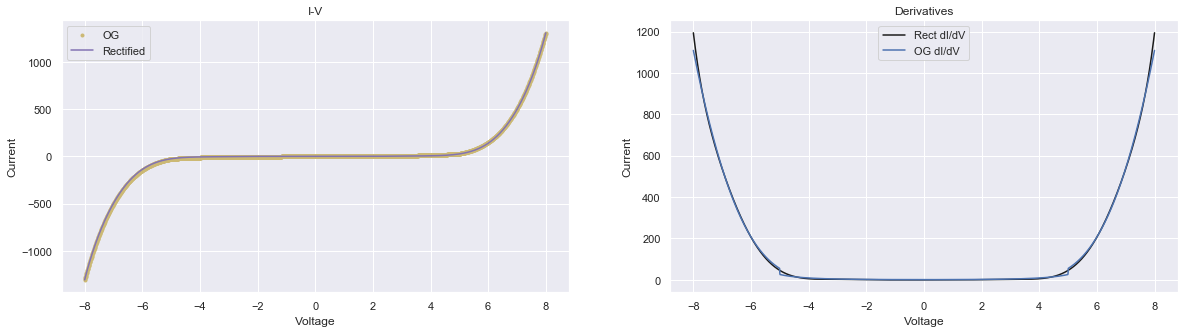

In [21]:
## Simmons Model Example ##

E0 = np.linspace(-8,8,2002)
t=np.linspace(-4,4,2002)

I = current(Simmons = True)
Q = Q_data1(t=t, V=signal, I=I, E0=E0) # generate rectified Q data
rec = rectify1(V=signal, Q=Q , E0=E0 , t=t, fit_terms=12) # rectify current


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(E0,I.calculate(E0), 'y.', label = "OG")
ax1.set_title('I-V')
ax1.set_xlabel("Voltage")
ax1.set_ylabel('Current')
ax1.plot(E0,rec[0],'m-', label='Rectified')
ax1.legend()


ax2.plot(E0[:-1], np.diff(rec[0])/np.diff(E0), 'k', label='Rect dI/dV')
ax2.plot(E0[:-1], np.diff(I.calculate(E0))/np.diff(E0), label="OG dI/dV")
ax2.set_title('Derivatives')
ax2.set_xlabel("Voltage")
ax2.set_ylabel('Current')
ax2.legend()

In [22]:
ax1.plot(E0,I.calculate(E0), 'y.', label = "OG")
ax1.set_title('I-V')
ax1.set_xlabel("Voltage")
ax1.set_ylabel('Current')
ax1.plot(E0,rec[0],'m-', label='Rectified')
ax1.legend()


ax2.plot(E0[:-1], np.diff(rec[0])/np.diff(E0), 'k', label='Rect dI/dV')
ax2.plot(E0[:-1], np.diff(I.calculate(E0))/np.diff(E0), label="OG dI/dV")
ax2.set_title('Derivatives')
ax2.set_xlabel("Voltage")
ax2.set_ylabel('Current')
ax2.legend()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


### 2.3 Simmons I-V Reconstruction Using a Real Waveform

This section tries to reconstruct a simulated I-V using a real waveform. More information can be found in Real_data_implementation.ipynb

In [24]:
file = 'sample_data/Symmetric_waveform_short_scan_window.txt'
short_sym = pd.read_csv(file, delimiter = '\t') # import data set
short_sym.drop(short_sym.index[[0]]) # dropping extra row
short_sym.head() # print first five data points

,Time,Electric field
0,-5.00,-0.000571
1,-4.98,-0.000756
2,-4.96,-0.001311
3,-4.94,-0.002237
4,-4.92,-0.002052


Text(0.5, 0, 'Time')

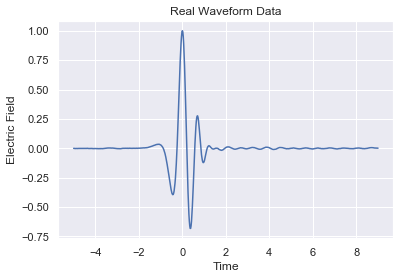

In [25]:
time = short_sym['Time'].values # make columns matrix
efield = short_sym["Electric field"].values
plt.plot(time, efield)
plt.title("Real Waveform Data")
plt.ylabel("Electric Field")
plt.xlabel("Time")

In [26]:
## Generating Q(V) Data and Rectify Current ##

E0 = np.linspace(-8,8,2002)
t=np.linspace(-4,4,2002) # try to keep consistent with rest of notebook
I = current(Simmons = True)
Q = Q_data1(t=time, V=efield, I=I, E0=E0) # generate rectified Q data
rec_I = rectify1(V=efield, E0=E0, t=time, Q=Q, fit_terms=12)

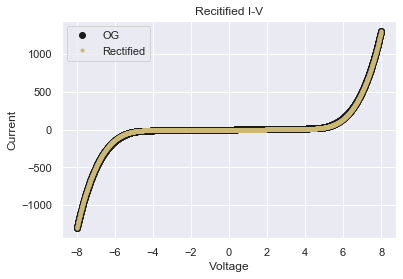

In [27]:
plt.plot(E0, I.calculate(E0), 'ko', label = 'OG')
plt.plot(E0, rec_I[0], 'y.', label = 'Rectified')
plt.title('Recitified I-V')
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.legend()

### 2.4 Reconstructing I-V Curve from Experimental Q(V) Data

Note: There seems to be a discrepency between the units of the experimental and reconstructed I-V.

In [30]:
file = 'sample_data/THz_waveform.txt'
waveform = pd.read_csv(file, delimiter = '\t')
time = waveform['-3.6025'].values
THz = waveform['-0.00369'].values
#waveform.head()

In [31]:
file = 'figures/THz-IE Fig 3e Nature Physics.txt'
I_E = pd.read_csv(file, delimiter = '\t') # import data set
I_eField = I_E['I_THz'].values
I_eCharge = I_E['E_THz,pk'].values
# I_E.head()

In [32]:
file = 'figures/IV for THz-IE Fig 3e Nature Physics.txt'
I_V = pd.read_csv(file, delimiter = '\t')
I_V = I_V.drop(columns=['Unnamed: 2'])
I_vVolt = I_V['V'].values
I_vCurrent = I_V['Current'].values
# I_V.head()

In [33]:
real_IV = rectify1(V=THz, E0 = I_eField, t=time, Q=I_eCharge, fit_terms=10)

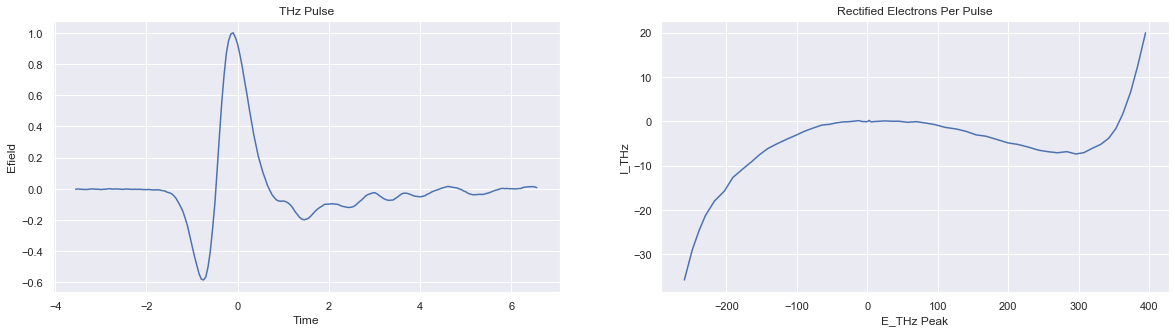

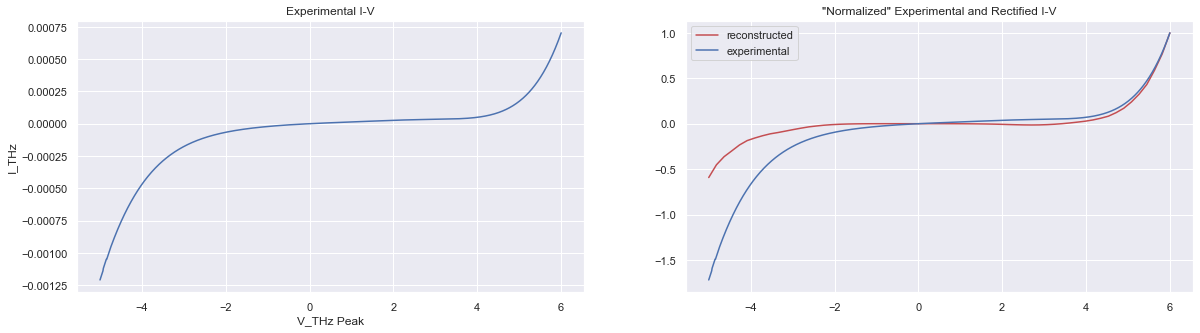

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
fig, (ax3, ax4) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(time,THz)
ax1.set_title("THz Pulse")
ax1.set_xlabel("Time")
ax1.set_ylabel("Efield")

ax2.plot(I_eField,I_eCharge)
ax2.set_xlabel('E_THz Peak')
ax2.set_ylabel('I_THz')
ax2.set_title('Rectified Electrons Per Pulse')

ax3.plot(I_vVolt,I_vCurrent)
ax3.set_xlabel("V_THz Peak")
ax3.set_ylabel("I_THz")
ax3.set_title('Experimental I-V')

E0 = np.linspace(-5,6, len(real_IV[0]))
ax4.plot(E0, real_IV[0]/max(real_IV[0]),'r', label= 'reconstructed')
ax4.plot(I_vVolt,I_vCurrent/max(I_vCurrent), label = 'experimental')
ax4.set_title('"Normalized" Experimental and Rectified I-V')
ax4.legend()

## Part 3: Emitted Field 

This part focuses on simulating the emitted field at the tunneling junction described by dI/dt. The FFT of this signal is taken to see which frequencies are present in this field. This section also explores how these quantities change as a function of driving amplitudes (input waveform maximums).

### 3.1 Wave Generation

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Phase')

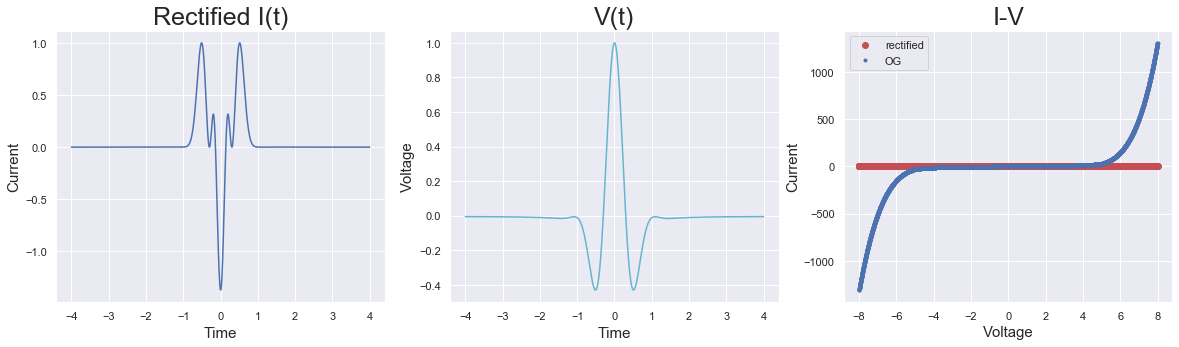

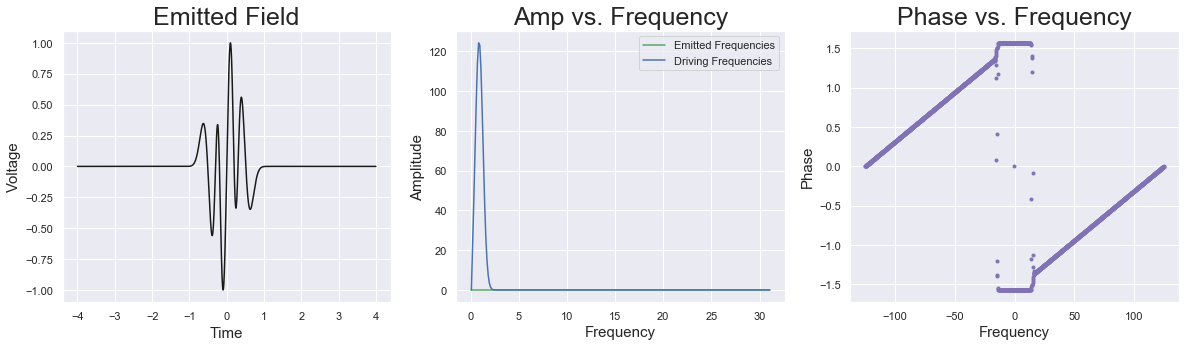

In [36]:
## Generating Q(V) data ##

pos_E0 = np.linspace(0,8,2002)
neg_E0 = np.linspace(-8,0,2002)
E0 = np.concatenate((neg_E0,pos_E0),axis=0)
t=np.linspace(-4,4,2002) # try to keep consistent with rest of notebook

I = current(Simmons = True)
Q = Q_data1(t=t, V=signal, I=I, E0=pos_E0) # generate rectified Q data
rec = rectify2(V=signal, pos_E0=pos_E0, neg_E0=neg_E0, t=t, Q_pos=Q[0], Q_neg=Q[1], fit_terms=12)


IFT = fourier(t,np.diff(rec[1])/np.diff(t))
ft = fourier(t , func = Efield(t))



fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,5))


ax1.plot(t, rec[1]/max(rec[1]))
ax1.set_title("Rectified I(t)",fontsize=25)
ax1.set_xlabel("Time",fontsize=15)
ax1.set_ylabel("Current",fontsize=15)

ax2.plot(t, signal, 'c')
ax2.set_title("V(t)",fontsize=25)
ax2.set_xlabel("Time",fontsize=15)
ax2.set_ylabel("Voltage",fontsize=15)

ax3.plot(E0, rec[0], 'ro', label = 'rectified')
ax3.plot(E0, I.calculate(E0), '.', label = 'OG')
ax3.set_title("I-V",fontsize=25)
ax3.set_xlabel("Voltage",fontsize=15)
ax3.set_ylabel("Current",fontsize=15)
ax3.legend()

ax4.plot(t[:-1], np.diff(rec[1])/np.diff(t)/max(np.diff(rec[1])/np.diff(t)), 'k')
ax4.set_title("Emitted Field",fontsize=25)
ax4.set_xlabel("Time",fontsize=15)
ax4.set_ylabel("Voltage",fontsize=15)

ax5.plot(IFT[0][1001:1250], np.abs(IFT[2])[1001:1250], 'g', label = "Emitted Frequencies")  
ax5.set_title("Amp vs. Frequency", fontsize=25)
ax5.set_xlabel("Frequency",fontsize=15)
ax5.set_ylabel("Amplitude",fontsize=15)
ax5.plot(ft[0][1001:1250], np.abs(ft[2])[1001:1250], label = "Driving Frequencies")
ax5.legend()

ax6.plot(IFT[0][:-1], np.angle(IFT[2]), 'm.')
ax6.set_title("Phase vs. Frequency",fontsize=25)
ax6.set_xlabel("Frequency",fontsize=15)
ax6.set_ylabel("Phase",fontsize=15)

### Sweeping I(t)

In [37]:
def current_sweep(V, E0, t, a_n, theory = False, rectified = False):
    
    """This function creates a 3D map of I(t), dI/dt, and the emitted field FFT 
        as a function of driving voltage amplitude (waveform maximums). You can feed in either a theoretical I-V 
        or an I-V that has been rectified in a previous section.
        
        ***PARAMETERS***
        
        V: Waveform.
        E0: Array of waveform amplitudes.
        t: Time axis.
        a_n: Fitting coefficients
        theory: Toggle if feeding in theoretical model.
        rectified: Toggle if feeding in rectified I-V.
        
        """
    
    if theory == True and rectified == True or theory == False and rectified == False:
        
        return print('Error: Select current type')
      
    
    elif rectified == True:
        
        I_map = np.zeros((len(V),len(E0)))
        Idt_map = np.zeros((len(V), len(E0)-1))
        IFT_map = np.zeros((len(V), len(E0)-1))
        
        
    
        for j in range(0,len(E0)):
            
            I_t = []
            
            for i in range(0,len(a_n)):
                I_t.append(a_n[i]*V**(i+2)*E0[j])
            
            I_t = np.sum(I_t, axis = 0)
            I_dt = np.diff(I_t)/np.diff(t)
            IFT = fourier(t, I_dt)
            
            I_map[j,:] = I_t 
            Idt_map[j,:] = I_dt
            IFT_map[j,:] = np.abs(IFT[2])
            
            
                       
            
    elif theory == True:
        
        I_map = [] 
        Idt_map = []
        IFT_map = []
        
        
        for i in range(0, len(E0)):
            I_map.append(I.calculate(E0[i]*V))
            Idt_map.append(np.diff(I.calculate(E0[i]*V))/np.diff(t))
            IFT = fourier(t, np.diff(I.calculate(E0[i]*V))/np.diff(t))
            IFT_map.append(np.abs(IFT[2]))
        
        I_map = np.asarray(I_map)
        Idt_map = np.asarray(Idt_map)
        IFT_map = np.asarray(IFT_map)
    
      
    
    return [I_map, Idt_map, IFT[0], IFT_map]
                
                



In [38]:
rec_map = current_sweep(V=signal, E0 = pos_E0, t=t, a_n = rec[2], rectified = True) # make rectified example

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


In [39]:
I = current(Simmons = True) # make theoretical example
theory_map = current_sweep(V=signal, E0 = pos_E0, t=t, a_n = rec[2], theory = True)

Text(0, 0.5, 'E0')

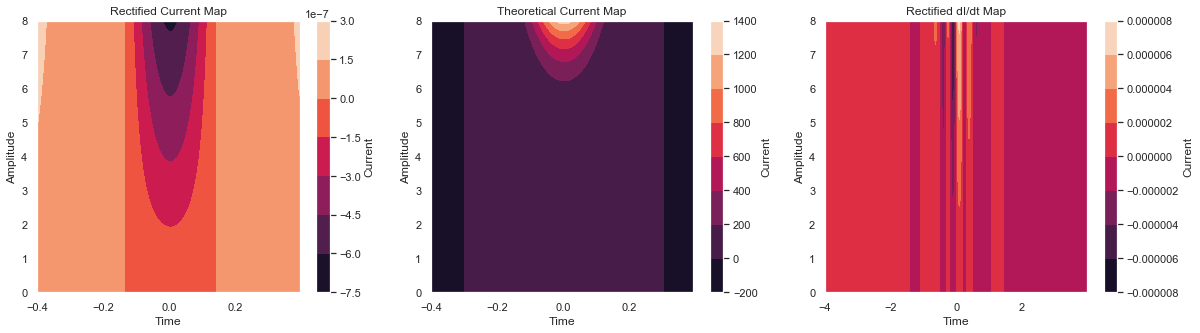

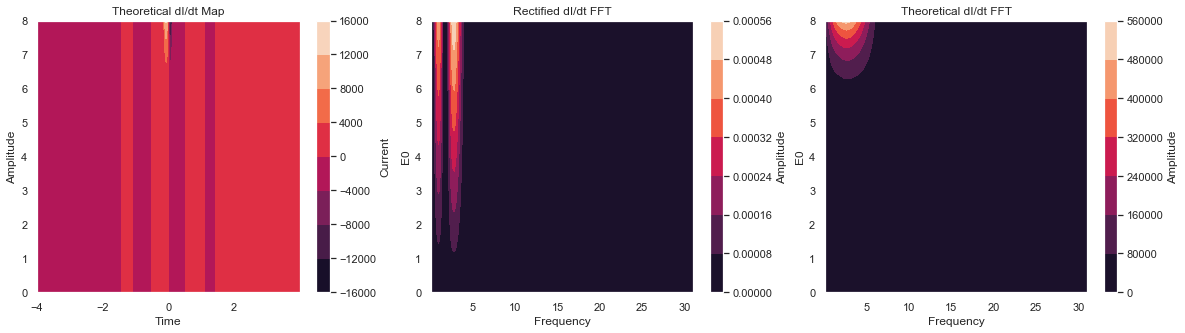

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,5))

cep1 = ax1.contourf(t[900:1100], pos_E0, rec_map[0][:,900:1100]) # contour (color) map 
plt.colorbar(cep1,ax=ax1, label = 'Current') # apply colorbar
ax1.set_title('Rectified Current Map')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

cep2 = ax2.contourf(t[900:1100], pos_E0, theory_map[0][:,900:1100]) # contour (color) map 
plt.colorbar(cep2, ax=ax2, label = 'Current')# apply colorbar
ax2.set_title('Theoretical Current Map')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

cep3 = ax3.contourf(t[:-1], pos_E0, rec_map[1]) # contour (color) map 
plt.colorbar(cep3, ax=ax3, label = 'Current') # apply colorbar
ax3.set_title('Rectified dI/dt Map')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

cep4 = ax4.contourf(t[:-1], pos_E0, theory_map[1]) # contour (color) map 
plt.colorbar(cep4, ax=ax4, label = 'Current') # apply colorbar
ax4.set_title('Theoretical dI/dt Map')
ax4.set_xlabel('Time')
ax4.set_ylabel('Amplitude')

cep5 = ax5.contourf(rec_map[2][1001:1250], pos_E0, rec_map[3][:,1001:1250]) # contour (color) map 
plt.colorbar(cep5, ax=ax5, label = 'Amplitude') # apply colorbar
ax5.set_title('Rectified dI/dt FFT')
ax5.set_xlabel('Frequency')
ax5.set_ylabel('E0')

cep6 = ax6.contourf(theory_map[2][1001:1250], pos_E0, theory_map[3][:,1001:1250]) # contour (color) map 
plt.colorbar(cep6, ax=ax6, label = 'Amplitude') # apply colorbar
ax6.set_title('Theoretical dI/dt FFT')
ax6.set_xlabel('Frequency')
ax6.set_ylabel('E0')

